# Camada SILVER – Análise Exploratória de Dados

## Descrição Geral

Este notebook tem como propósito realizar o **carregamento e a análise exploratória** dos dados inseridos na **camada SILVER** da Data Layer.  
Nessa etapa, são utilizados os arquivos que já passaram por processos de **limpeza, padronização e enriquecimento** na camada anterior (RAW).
Os dados estão estruturados, validados e prontos para análises mais aprofundadas. O objetivo é compreender as relações entre entidades, identificar padrões e preparar insights que serão utilizados nas análises finais da camada Gold.

## Configuração Inicial

A primeira parte do notebook é dedicada à preparação do ambiente de trabalho, incluindo:

- **Importação das bibliotecas essenciais**, como `pandas`, `numpy`, `matplotlib` e `seaborn`, com breve explicação de seus papéis na análise.  
- **Definição dos caminhos** para os arquivos localizados na camada SILVER.  
- **Levantamento de metadados** iniciais, como tipos de dados, quantidade de registros, integridade referencial e qualidade dos dados após o pré-processamento.

Ao final desta etapa, espera-se ter uma visão clara sobre a **qualidade, estrutura e relacionamentos dos dados processados**, bem como identificar oportunidades para análises mais complexas na próxima camada.


In [9]:
import psycopg2
from psycopg2 import sql
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

DB_CONFIG = {
    'host': 'localhost',      
    'port': 5432,             
    'database': 'f1_dw',      
    'user': 'user_f1',        
    'password': 'password_f1' 
}

print("✓ Bibliotecas importadas (psycopg2, pandas, datetime).")
print(f"✓ Configuração de conexão: {DB_CONFIG['database']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}")

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    
    print("✓ Conexão com o banco de dados PostgreSQL estabelecida com sucesso!")
    print("\nVariáveis 'conn' e 'cursor' estão prontas para uso.")
    
except psycopg2.OperationalError as e:
    print(f"✗ ERRO CRÍTICO DE CONEXÃO: Não foi possível conectar ao banco de dados.")
    print(f"   Detalhes: {e}")
    print("   Verifique se o container Docker 'postgres' está rodando.")


✓ Bibliotecas importadas (psycopg2, pandas, datetime).
✓ Configuração de conexão: f1_dw@localhost:5432
✓ Conexão com o banco de dados PostgreSQL estabelecida com sucesso!

Variáveis 'conn' e 'cursor' estão prontas para uso.


___
### Carregando as tabelas do banco - Schema Silver -  em Dataframes

In [ ]:
TABLE_NAMES_SILVER = [
    'circuits_silver', 'races_silver', 'drivers_silver', 'constructors_silver',
    'results_silver', 'constructor_results_silver', 'driver_standings_silver',
    'constructor_standings_silver', 'qualifying_silver', 'lap_times_silver',
    'pit_stops_silver', 'seasons_silver', 'status_silver', 'sprint_results_silver'
]

print("Iniciando o carregamento das tabelas Silver para DataFrames Pandas:")

for table_name in TABLE_NAMES_SILVER:
    query = f"SELECT * FROM silver.{table_name}"
    
    try:
        df = pd.read_sql_query(query, conn)
        
        df_var_name = f"df_{table_name}"
        globals()[df_var_name] = df
        
        print(f"✅ DataFrame '{df_var_name}' carregado (Linhas: {len(df)})")
        
    except Exception as e:
        print(f"❌ Erro ao carregar a tabela {table_name}: {e}")

print("\n✓ Carregamento de todos os DataFrames Silver concluído.")

Iniciando o carregamento das tabelas Silver para DataFrames Pandas:
✅ DataFrame 'df_circuits_silver' carregado (Linhas: 77)
✅ DataFrame 'df_races_silver' carregado (Linhas: 1125)
✅ DataFrame 'df_drivers_silver' carregado (Linhas: 861)
✅ DataFrame 'df_constructors_silver' carregado (Linhas: 212)
✅ DataFrame 'df_results_silver' carregado (Linhas: 26759)
✅ DataFrame 'df_constructor_results_silver' carregado (Linhas: 12625)
✅ DataFrame 'df_driver_standings_silver' carregado (Linhas: 34863)


/tmp/ipykernel_210881/2351316993.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


✅ DataFrame 'df_constructor_standings_silver' carregado (Linhas: 13391)
✅ DataFrame 'df_qualifying_silver' carregado (Linhas: 10494)
✅ DataFrame 'df_lap_times_silver' carregado (Linhas: 589081)
✅ DataFrame 'df_pit_stops_silver' carregado (Linhas: 11371)
✅ DataFrame 'df_seasons_silver' carregado (Linhas: 75)
✅ DataFrame 'df_status_silver' carregado (Linhas: 139)
✅ DataFrame 'df_sprint_results_silver' carregado (Linhas: 360)

✓ Carregamento de todos os DataFrames Silver concluído.


___
### Análise Descritiva - Data Quality | Conteúdo

In [7]:
print("\n[1] Top 5 Nacionalidades de Pilotos:")
pilotos_por_nacao = df_drivers_silver['nationality'].value_counts().nlargest(5)
print(pilotos_por_nacao.to_markdown(numalign="left", stralign="left"))

min_year = df_races_silver['year'].min()
max_year = df_races_silver['year'].max()
total_races = len(df_races_silver)

print(f"\n[2] Cobertura Histórica de Corridas:")
print(f" - Período: {min_year} a {max_year}")
print(f" - Total de Corridas (Registros): {total_races}")

STATUS_FINISHED_ID = 1 
df_dnf_status = df_status_silver[df_status_silver['status_id'] != STATUS_FINISHED_ID]

print(f"\n[3] Top 3 Razões para DNF/DSQ (Excluindo 'Finished'):")
dnf_counts = df_dnf_status['status'].value_counts().nlargest(3)
print(dnf_counts.to_markdown(numalign="left", stralign="left"))
print("\n[4] Estatísticas Descritivas das Métricas Centrais:")
results_stats = df_results_silver[['points', 'position_order']].describe().T
print(results_stats[['count', 'mean', 'std', 'min', 'max']].to_markdown(numalign="left", stralign="left"))



[1] Top 5 Nacionalidades de Pilotos:
| nationality   | count   |
|:--------------|:--------|
| British       | 166     |
| American      | 158     |
| Italian       | 99      |
| French        | 73      |
| German        | 50      |

[2] Cobertura Histórica de Corridas:
 - Período: 1950 a 2024
 - Total de Corridas (Registros): 1125

[3] Top 3 Razões para DNF/DSQ (Excluindo 'Finished'):
| status       | count   |
|:-------------|:--------|
| Disqualified | 1       |
| Accident     | 1       |
| Collision    | 1       |

[4] Estatísticas Descritivas das Métricas Centrais:
|                | count   | mean    | std     | min   | max   |
|:---------------|:--------|:--------|:--------|:------|:------|
| points         | 26759   | 1.98763 | 4.35121 | 0     | 50    |
| position_order | 26759   | 12.7941 | 7.66595 | 1     | 39    |


___
### Disperção dos dados - Heatmap (Piloto vs. Ano)

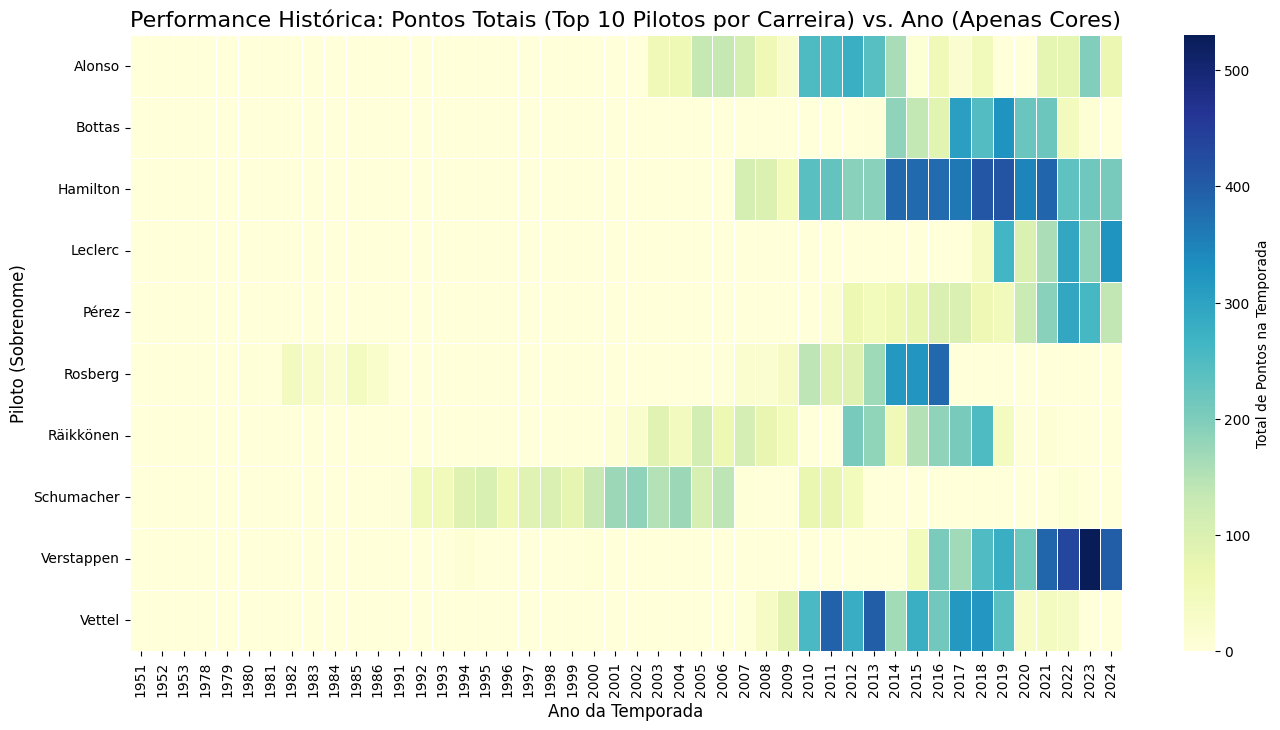

In [ ]:
df_pontos_por_corrida = df_results_silver.merge(
    df_races_silver[['race_id', 'year']],
    on='race_id',
    how='inner'
)
df_piloto_pontos_ano = df_pontos_por_corrida.merge(
    df_drivers_silver[['driver_id', 'surname']],
    on='driver_id',
    how='inner'
)

df_piloto_total_pontos = df_piloto_pontos_ano.groupby('surname')['points'].sum().nlargest(10).index.tolist()
df_heatmap_data = df_piloto_pontos_ano[
    df_piloto_pontos_ano['surname'].isin(df_piloto_total_pontos)
]

df_heatmap_pivot = df_heatmap_data.groupby(['surname', 'year'])['points'].sum().unstack()
df_heatmap_plot = df_heatmap_pivot.fillna(0)

plt.figure(figsize=(16, 8))
sns.heatmap(
    df_heatmap_plot, 
    annot=False,          
    fmt=".1f",           
    cmap="YlGnBu",       
    linewidths=.5,       
    cbar_kws={'label': 'Total de Pontos na Temporada'}
)

plt.title('Performance Histórica: Pontos Totais (Top 10 Pilotos por Carreira) vs. Ano (Apenas Cores)', fontsize=16)
plt.xlabel('Ano da Temporada', fontsize=12)
plt.ylabel('Piloto (Sobrenome)', fontsize=12)
plt.show()


___
### Posição média de chegada

/tmp/ipykernel_210881/2286736335.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


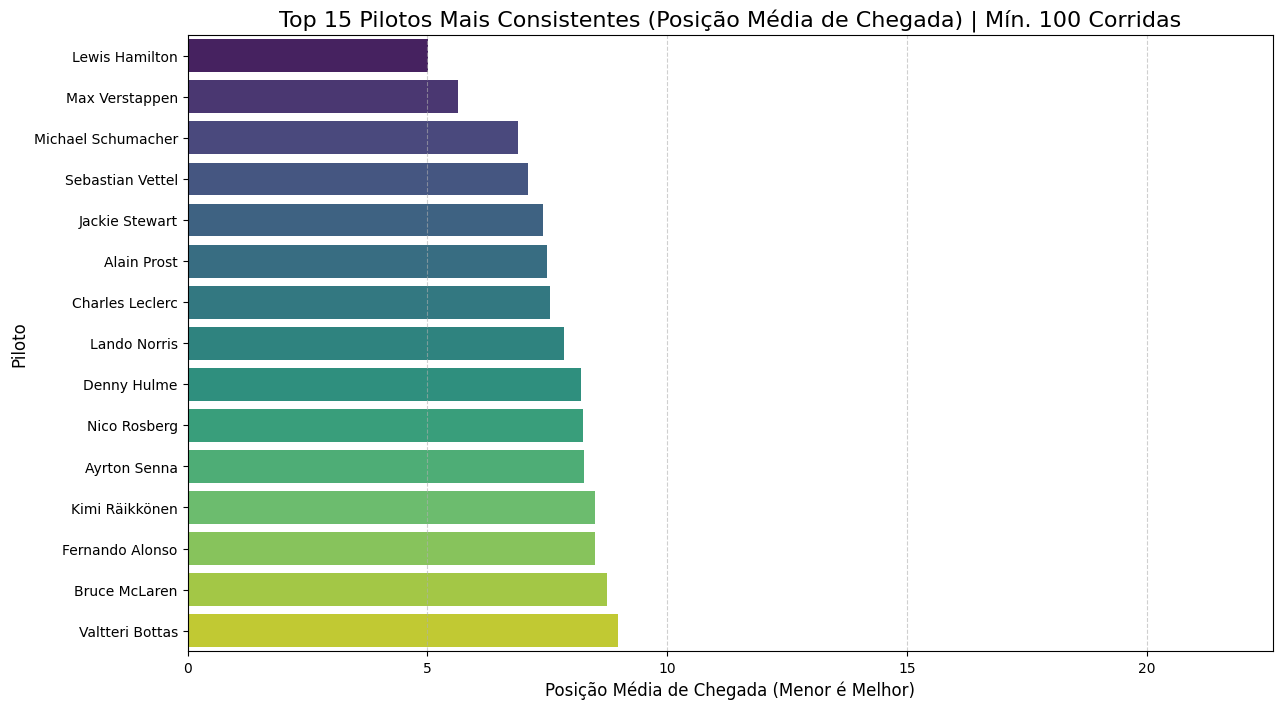

In [19]:
df_bar_data = df_results_silver.merge(
    df_drivers_silver[['driver_id', 'forename', 'surname']],
    on='driver_id',
    how='inner'
)
df_bar_data['pilot_full_name'] = df_bar_data['forename'] + ' ' + df_bar_data['surname']
df_bar_data = df_bar_data[df_bar_data['position_order'] > 0]

df_ranking = df_bar_data.groupby('pilot_full_name').agg(
    avg_position=('position_order', 'mean'),
    total_races=('result_id', 'count')
).reset_index()

MIN_RACES = 100
df_ranking = df_ranking[df_ranking['total_races'] >= MIN_RACES]
df_ranking = df_ranking.sort_values(by='avg_position', ascending=True)


plt.figure(figsize=(14, 8))
sns.barplot(
    x='avg_position',
    y='pilot_full_name',
    data=df_ranking.head(15), 
    palette="viridis"
)
plt.title(f'Top 15 Pilotos Mais Consistentes (Posição Média de Chegada) | Mín. {MIN_RACES} Corridas', fontsize=16)
plt.xlabel('Posição Média de Chegada (Menor é Melhor)', fontsize=12)
plt.ylabel('Piloto', fontsize=12)


plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, df_ranking['avg_position'].max() + 1) 
plt.show()


/tmp/ipykernel_210881/1138165927.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


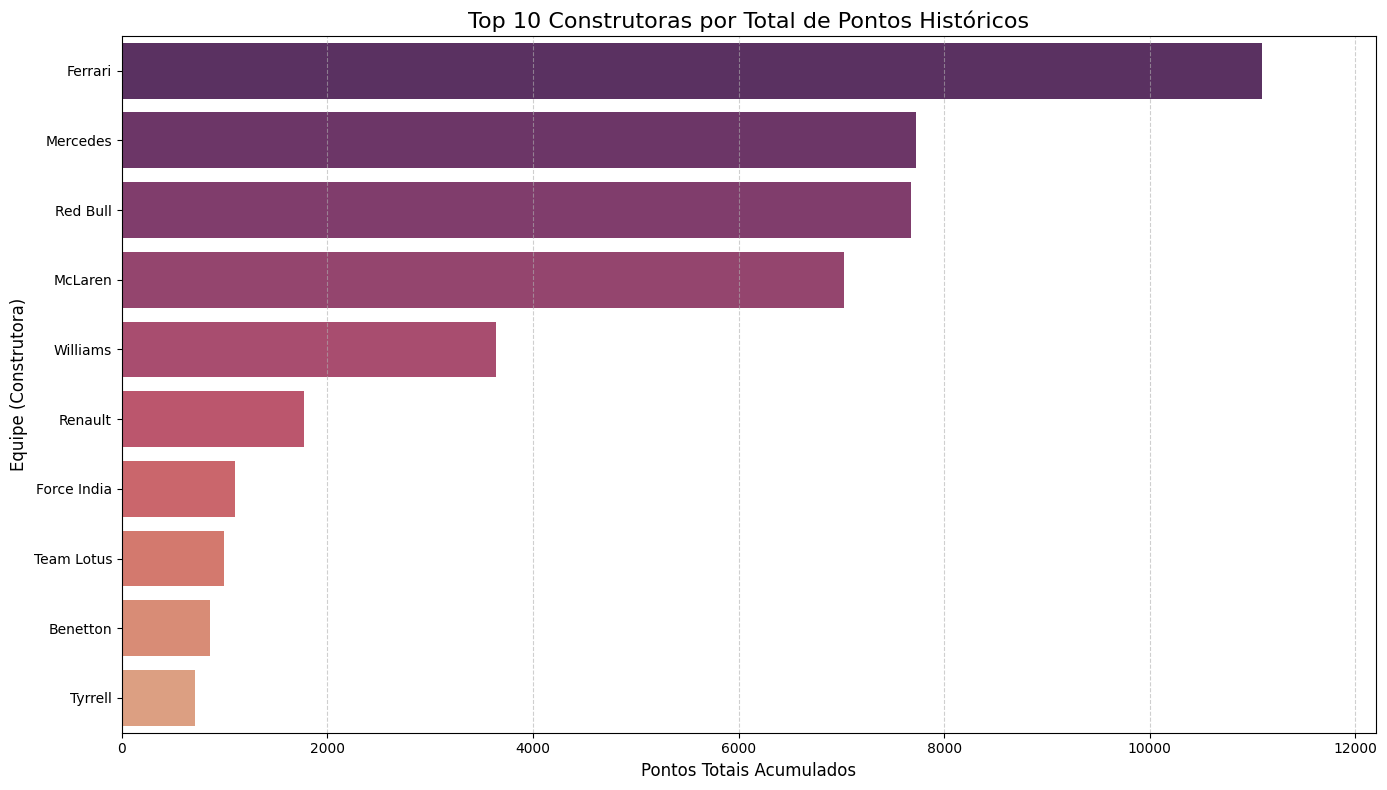

In [ ]:
df_bar_data = df_results_silver.merge(
    df_constructors_silver[['constructor_id', 'name']],
    on='constructor_id',
    how='inner'
).rename(columns={'name': 'team_name'})

df_team_ranking = df_bar_data.groupby('team_name').agg(
    total_points=('points', 'sum')
).reset_index()

df_team_ranking = df_team_ranking.sort_values(by='total_points', ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(
    x='total_points',
    y='team_name',
    data=df_team_ranking,
    palette="flare_r" 

plt.title('Top 10 Construtoras por Total de Pontos Históricos', fontsize=16)
plt.xlabel('Pontos Totais Acumulados', fontsize=12)
plt.ylabel('Equipe (Construtora)', fontsize=12)


plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xlim(0, df_team_ranking['total_points'].max() * 1.1) # Ajustar limite X
plt.tight_layout()
plt.show()